## Instal·lació i imports de les llibreries necessàries ##

In [99]:
!pip install nltk unidecode numpy pandas matplotlib seaborn vaderSentiment scikit-learn

In [100]:
import nltk
nltk.download(['movie_reviews', 'wordnet', 'punkt', 'sentiwordnet', 'averaged_perceptron_tagger_eng'])
from nltk.corpus import movie_reviews as mr, wordnet as wn, sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.wsd import lesk

from unidecode import unidecode
import numpy as np
import pandas as pd
import random
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import re


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (recall_score, precision_score, accuracy_score, f1_score, 
                             roc_auc_score, roc_curve, auc, confusion_matrix, 
                             ConfusionMatrixDisplay, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Elias\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Elias\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Elias\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Funció del preprocessat ##
El que fa aquesta funció és: passar text a minúscules, treure accents, eliminar nombres, eliminar signes de puntuació i passar a lema.

In [101]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()    
    text = text.lower() # Passar a minúscules
    text = unidecode(text) # Treure accents
    text = re.sub(r'\d+', '', text) # Eliminar nombres
    tokens = word_tokenize(text) # Tokenitzar
    tokens = [word for word in tokens if word.isalnum()] # Eliminar signes de puntuació
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Ens quedem amb el lema
    return ' '.join(tokens)

## Lectura i particionat de les dades ##
El que fem en aquest apartat serà seleccionar les dades de la llibreria de nltk, fer el particionat amb 80% pel train i 20% pel test (no cal conjunt de validació perqué farem validació creuada) i, finalment, llegir cada opinió, preprocessar-la i posar-la a la llista.

In [102]:
def preparar_splits():
    positive = mr.fileids('pos') # Llista de fitxers amb crítiques positives
    negative = mr.fileids('neg') # Llista de fitxers amb crítiques negatives

    positive_train = positive[:800] # Seleccionem el 80% de les crítiques positives per entrenar
    positive_test = positive[800:] # Seleccionem el 20% de les crítiques positives per testejar

    negative_train = negative[:800] # El mateix per les negatives
    negative_test = negative[800:]

    train = positive_train + negative_train # Creem la llista d'entrenament concatenant les dues llistes anteriors
    test = positive_test + negative_test

    train_x = [' '.join(mr.words(fileid)) for fileid in train] # Creem una llista llegint les crítiques
    test_x = [' '.join(mr.words(fileid)) for fileid in test]

    train_x = [preprocess_text(doc) for doc in train_x] # Preprocessament de les crítiques
    test_x = [preprocess_text(doc) for doc in test_x]

    train_y = [1] * 800 + [0] * 800 # Creem la llista de labels
    test_y = [1] * 200 + [0] * 200

    return train_x, test_x, train_y, test_y

## Models supervisats ##
En aquesta secció el que farem serà provar diferents models per tal de trobar el que doni millors resultats. Tot i que l'ideal seria tunejar el model de predicció i el de vectorització a la vegada, el que farem serà, en aquesta primera fase provar unes poques combinacions per a cada un i, després, tunejar el model final, pel fet que això és menys costós.

In [103]:
def diccionari_params(model): # Funció que retorna un diccionari amb els paràmetres per fer la cerca de hiperparàmetres per a un model concret
    if model == 'LR':
        params = {'classifier__C': [ 0.1, 1.0, 10.0],'classifier__max_iter': [1000], 'classifier__random_state': [42]}
    elif model == 'SVM':
        params = {'classifier__C': [0.1, 1.0, 10.0]}
    elif model == 'NB':
        params = {'classifier__alpha': [0.0, 1, 10]}
    elif model == 'KNN':
        params = {'classifier__n_neighbors': [1, 3, 5]}
    elif model == 'RF':
        params = {'classifier__n_estimators': [50, 100, 200]}
    elif model == 'GBM':
        params = {'classifier__learning_rate': [0.1, 0.01, 0.001]}
    params_vec ={'vectorizer__max_df': [1.0, 0.8, 0.6], 'vectorizer__min_df': [0.0, 0.1, 0.2, 0.4], 'vectorizer__stop_words': ['english'],'vectorizer': [CountVectorizer(), TfidfVectorizer()]}
    return params | params_vec

In [104]:
from sklearn.model_selection import GridSearchCV
models = {'LR': LogisticRegression(), 'NB': MultinomialNB(), 'RF': RandomForestClassifier(), 'KNN': KNeighborsClassifier(), 'GBM': GradientBoostingClassifier(), 'SVM': SVC()}

def gridsearch(model, param_grid): # Funció principal que executa la cerca de hiperparàmetres per a un model concret i amb els seus respectius paràmetres
    train_x, test_x, train_y, test_y = preparar_splits() # Carreguem les dades
    
    pipeline = Pipeline([('vectorizer', CountVectorizer()), ('classifier', models[model])]) # Creem el pipeline amb el vectoritzador i el classificador
      
    grid_search = GridSearchCV( # Creem l'objecte de cerca de hiperparàmetres
        pipeline,
        param_grid,
        cv=5,                
        scoring='accuracy',  
        verbose=1,           
        n_jobs=-1)
    
    grid_search.fit(train_x, train_y) # Entrenem el model
    
    print("\nMillors paràmetres:") # Mostrem els millors paràmetres
    for param, value in grid_search.best_params_.items():
        if param == 'vectorizer':
            print(f"  {param}: {type(value).__name__}")
        else:
            print(f"  {param}: {value}")
    
    accuracy = grid_search.best_score_
    print(f"\nAccuracy: {accuracy}")

    best_model = grid_search.best_estimator_ # Guardem el millor model
    y_pred = best_model.predict(test_x) # Fem les prediccions
    
    print("\nClassification report:") # Mostrem el classification report
    print(classification_report(test_y, y_pred, target_names=['neg', 'pos']))

    print("\nConfusion matrix:") # Mostrem la matriu de confusió
    cm = confusion_matrix(test_y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
    plt.xlabel('Predicció')
    plt.ylabel('Real')
    plt.title('Matriu de confusió')
    plt.show()

    long = len(best_model.named_steps['vectorizer'].vocabulary_) # Mostrem la longitud del vector
    print("\nLongitud del vector: ", long)

    y_pred_train = best_model.predict(train_x) # Fem les prediccions amb les dades d'entrenament
    print("\nAccuracy train: ", accuracy_score(train_y, y_pred_train))
    
    return best_model, accuracy

In [105]:
def trobar_millor_model(): # Funció que executa la cerca de hiperparàmetres per a tots els models
    res = {}
    for model in models:
        print(f"\nModel --> {model}")
        params = diccionari_params(model) # Obtenim els paràmetres per a cada model
        best_model, accuracy = gridsearch(model, params) # Executem la cerca de hiperparàmetres
        res[model] = accuracy # Guardem l'accuracy de cada model

    df = pd.DataFrame(list(res.items()), columns=['Model', 'Accuracy']) # Creem un dataframe amb els resultats
    plt.figure(figsize=(8, 4))
    sns.heatmap(df.set_index('Model').T, annot=True, cmap="YlGnBu", cbar=False, fmt='.2f', linewidths=0.5)
    plt.title('Taula de les accuracies dels models', fontsize=16)
    plt.show()


Model --> LR
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Millors paràmetres:
  classifier__C: 10.0
  classifier__max_iter: 1000
  classifier__random_state: 42
  vectorizer: TfidfVectorizer
  vectorizer__max_df: 0.6
  vectorizer__min_df: 0.0
  vectorizer__stop_words: english

Accuracy: 0.8387500000000001

Classification report:
              precision    recall  f1-score   support

         neg       0.83      0.83      0.83       200
         pos       0.83      0.83      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400


Confusion matrix:


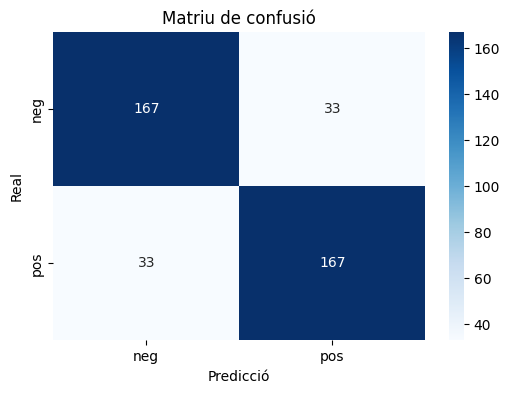


Longitud del vector:  31273

Accuracy train:  1.0

Model --> NB
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Millors paràmetres:
  classifier__alpha: 1
  vectorizer: TfidfVectorizer
  vectorizer__max_df: 0.8
  vectorizer__min_df: 0.0
  vectorizer__stop_words: english

Accuracy: 0.8168749999999999

Classification report:
              precision    recall  f1-score   support

         neg       0.76      0.82      0.79       200
         pos       0.81      0.73      0.77       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400


Confusion matrix:


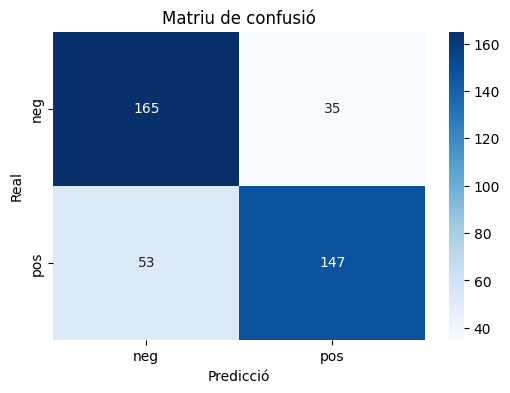


Longitud del vector:  31279

Accuracy train:  0.966875

Model --> RF
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Millors paràmetres:
  classifier__n_estimators: 200
  vectorizer: CountVectorizer
  vectorizer__max_df: 0.8
  vectorizer__min_df: 0.0
  vectorizer__stop_words: english

Accuracy: 0.82125

Classification report:
              precision    recall  f1-score   support

         neg       0.83      0.85      0.84       200
         pos       0.85      0.82      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400


Confusion matrix:


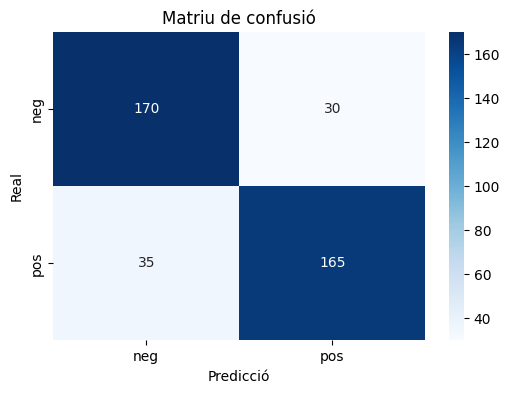


Longitud del vector:  31279

Accuracy train:  1.0

Model --> KNN
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Millors paràmetres:
  classifier__n_neighbors: 3
  vectorizer: TfidfVectorizer
  vectorizer__max_df: 0.8
  vectorizer__min_df: 0.0
  vectorizer__stop_words: english

Accuracy: 0.684375

Classification report:
              precision    recall  f1-score   support

         neg       0.66      0.65      0.65       200
         pos       0.66      0.68      0.67       200

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.66      0.66       400


Confusion matrix:


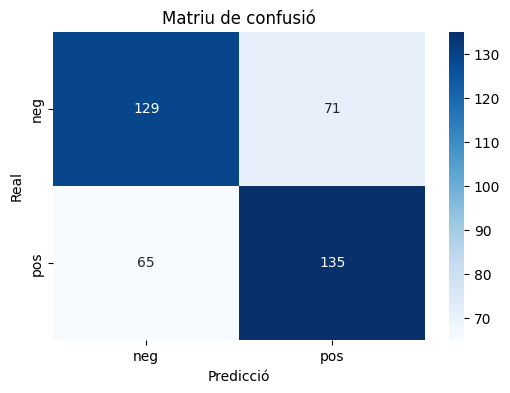


Longitud del vector:  31279

Accuracy train:  0.845625

Model --> GBM
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Millors paràmetres:
  classifier__learning_rate: 0.1
  vectorizer: CountVectorizer
  vectorizer__max_df: 0.8
  vectorizer__min_df: 0.0
  vectorizer__stop_words: english

Accuracy: 0.7925

Classification report:
              precision    recall  f1-score   support

         neg       0.82      0.77      0.79       200
         pos       0.78      0.83      0.81       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400


Confusion matrix:


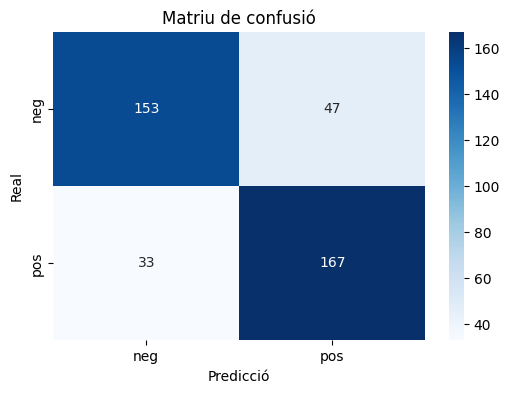


Longitud del vector:  31279

Accuracy train:  0.949375

Model --> SVM
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Millors paràmetres:
  classifier__C: 10.0
  vectorizer: TfidfVectorizer
  vectorizer__max_df: 0.6
  vectorizer__min_df: 0.0
  vectorizer__stop_words: english

Accuracy: 0.8300000000000001

Classification report:
              precision    recall  f1-score   support

         neg       0.81      0.83      0.82       200
         pos       0.83      0.81      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400


Confusion matrix:


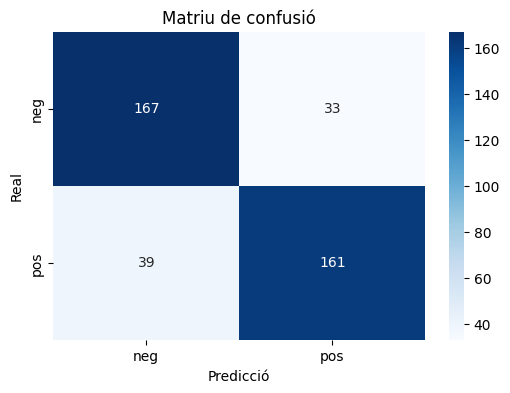


Longitud del vector:  31273

Accuracy train:  1.0


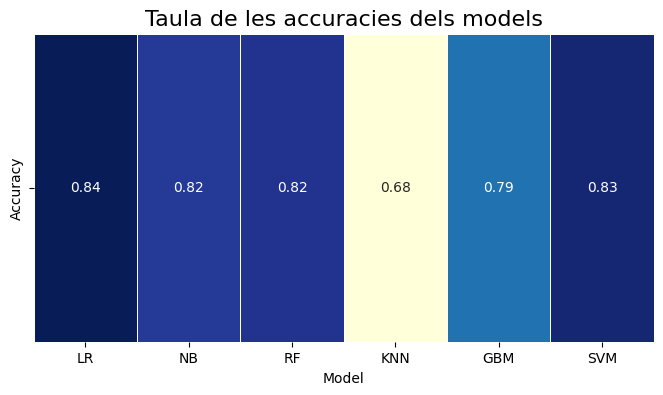

In [106]:
trobar_millor_model()

## Hiperparàmetres del millor model ##
Un cop vam veure que la regressió logística era el millor model vam passar a buscar els hiperparàmetres òptims. Per dur-ho a terme, vam seguir pràcticament els mateixos passos que anteriorment, de fet vam utilitzar les mateixes funcions, amb la diferència que, en aquest cas, la llista de paràmetres a provar és mol més extensa.

In [107]:
def tunejar_millor_model():
    train_x, test_x, train_y, test_y = preparar_splits()
    params = {'classifier__random_state': [27], 'classifier__max_iter': [500, 750, 1000],  'classifier__C': [ 0.1, 1.0, 10.0], 'classifier__solver': ['liblinear', 'lbfgs', 'saga'], 'vectorizer__max_df': [1.0, 0.8, 0.6], 'vectorizer__min_df': [0.0, 0.02, 0.04], 'vectorizer__stop_words': ['english'],'vectorizer': [CountVectorizer(), TfidfVectorizer()]}
    model_final, accuracy = gridsearch('LR', params) # Executem la funció de gridsearch, que ens retornarà el millor model
    return model_final

## Prediccions amb el millor model al test ##
Un cop sabem ja els hiperparàmetres òptims del nostre model, podem fer ja les prediccions per al test


In [108]:
def millor_model(pipeline): # Funció que ens permet avaluar el millor model, passem el millor model com a paràmetre
    train_x, test_x, train_y, test_y = preparar_splits()
    pipeline.fit(train_x, train_y) # Entrenem el model
    y_pred = pipeline.predict(test_x) # Fem les prediccions per les dades de test
    print('Accuracy:', accuracy_score(test_y, y_pred)) # Mostrem l'accuracy
    print('Classification report:') # Mostrem el classification report
    print(classification_report(test_y, y_pred, target_names=['neg', 'pos']))
    fpr, tpr, _ = roc_curve(test_y, y_pred) # Mostrem la curva ROC
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    print('Confusion matrix:') # Mostrem la matriu de confusió
    cm = confusion_matrix(test_y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg', 'pos'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    return y_pred

Fitting 5 folds for each of 486 candidates, totalling 2430 fits

Millors paràmetres:
  classifier__C: 10.0
  classifier__max_iter: 500
  classifier__random_state: 27
  classifier__solver: saga
  vectorizer: TfidfVectorizer
  vectorizer__max_df: 1.0
  vectorizer__min_df: 0.02
  vectorizer__stop_words: english

Accuracy: 0.8412499999999999

Classification report:
              precision    recall  f1-score   support

         neg       0.81      0.83      0.82       200
         pos       0.83      0.81      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400


Confusion matrix:


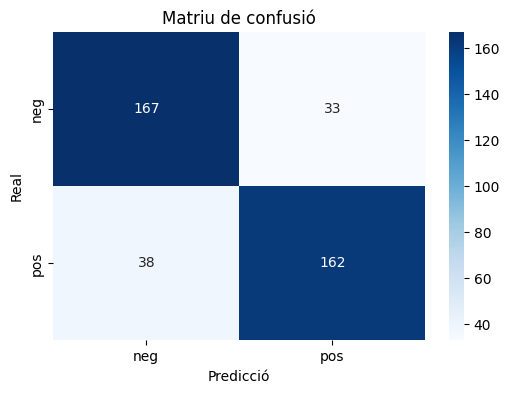


Longitud del vector:  2304

Accuracy train:  0.998125


In [109]:
model_final = tunejar_millor_model() # Executem la funció per trobar el millor model

Accuracy: 0.8225
Classification report:
              precision    recall  f1-score   support

         neg       0.81      0.83      0.82       200
         pos       0.83      0.81      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



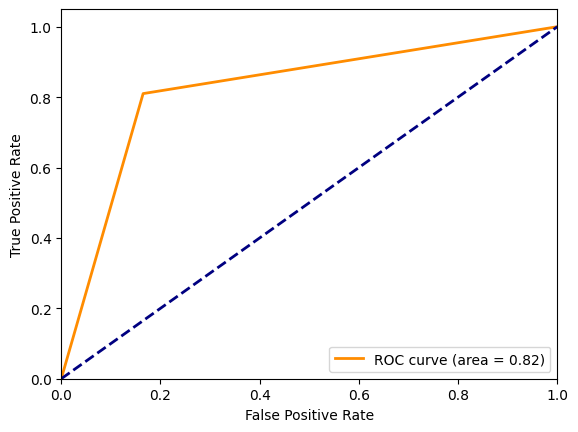

Confusion matrix:


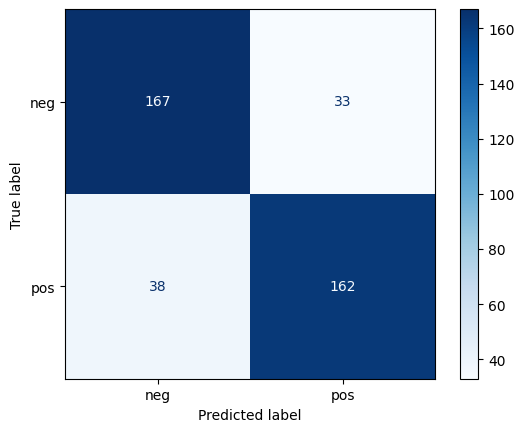

In [110]:
prediccions_supervisats = millor_model(model_final) # Fem les prediccions pel test amb el millor model

## Anàlisi d'errors ##
Per acabar, l'últim que farem serà fer un anàlisi dels errors per tal d'intentar detectar patrons i veure els principals punts dèbils del nostre model

In [111]:
errors_positives = []
errors_negatives = []
long_error = 0
adj_error = 0
correcte_positives = []
correcte_negatives = []
long_correcte = 0
adj_correcte = 0

train_x, test_x, train_y, test_y = preparar_splits()

for pred in range(len(prediccions_supervisats)):
    print(f'Opinió: {test_x[pred]} | Predicció: {prediccions_supervisats[pred]}, Real: {test_y[pred]}') # Mostrem les prediccions que no coincideixen amb les dades reals
    if prediccions_supervisats[pred] != test_y[pred]:
        if test_y[pred] == 1:
            errors_positives.append(test_x[pred])
        else:
            errors_negatives.append(test_x[pred])
        for word in test_x[pred].split():
            pos = pos_tag([word])[0][1] 
            if pos in ['JJ', 'JJR', 'JJS']: 
                adj_error += 1
        long_error += len(test_x[pred].split())
    else: 
        if test_y[pred] == 1:
            correcte_positives.append(test_x[pred])
        else:
            correcte_negatives.append(test_x[pred])
        for word in test_x[pred].split():
            pos = pos_tag([word])[0][1] 
            if pos in ['JJ', 'JJR', 'JJS']: 
                adj_correcte += 1
        long_correcte += len(test_x[pred].split())
    
print('-----------------------------------')
print('Longitud dels errors:', long_error/(len(errors_positives) + len(errors_negatives)))
print('Longitud dels correctes:', long_correcte/(len(correcte_negatives) + len(correcte_positives)))
print('-----------------------------------')
print('Adjectius dels errors:', adj_error/(len(errors_positives) + len(errors_negatives)))
print('Adjectius dels correctes:', adj_correcte/(len(correcte_negatives) + len(correcte_positives)))
print('-----------------------------------')
print()

def mostrar_errors(lst):
    vectorizer = CountVectorizer(min_df=0.2, stop_words='english')
    matrix = vectorizer.fit_transform(lst)
    word_counts = np.asarray(matrix.sum(axis=0)).flatten()
    vocab = np.array(vectorizer.get_feature_names_out())

    adjectives = []
    for word in vocab:
        pos = pos_tag([word])[0][1] 
        if pos in ['JJ', 'JJR', 'JJS']: 
            adjectives.append(word)

    df_freq = pd.DataFrame({'Paraula': vocab, 'Freqüència': word_counts})
    df_freq = df_freq[df_freq['Paraula'].isin(adjectives)]  
    df_freq = df_freq.sort_values(by='Freqüència', ascending=False)

    print(df_freq.head(10))

print('Real positiva | Predicció negativa')
mostrar_errors(errors_positives) # Mostrem els errors positius
print()
print('Real negativa | Predicció positiva')
mostrar_errors(errors_negatives) # Mostrem els errors negatius  

Opinió: those of you who frequently read my review are not likely to be surprised by the fact that i have not read victor hugo s novel le miserables i don t know if a lot of people have though i imagine many are familiar with the popular musical based on the novel i haven t even seen that going into this film i had almost no knowledge of the story or it character i even expected the film to be a musical walking away from it i m kind of glad i had no prior experience with the material writer director bille august s film version is a straightforward beautifully told film liam neeson star a the miserable jean valjean in the beginning he ha just been released from a year prison sentence he is allowed to stay in a convent by a kindly priest despite his rude and destructive behavior the priest s word of wisdom influence him and he make a vow to change himself nine year later we are informed that he is now the mayor of a town called vigo nobody know his real name and that he is wanted for ski

## Segona part: models no supervisats ##

Aqeusta vegada, a part de la funció de prerocessat que hem comentat a l'inici, també s'utilitza una funció per extreure els noms propis, que serveix per reduir els elements a comprovar. No modifica el resultats obtinguts, però disminueix el temps de computació.

In [112]:
train_x, test_x, train_y, test_y = preparar_splits() # Carreguem les dades

def eliminar_noms_propis(frase, counter):
    tokens = word_tokenize(frase)
    tagged = pos_tag(tokens)
    tokens_filtrats = []
    for paraula, tag in tagged:
        if tag not in ('NNP', 'NNPS'):
            tokens_filtrats.append(paraula)
        else:
            counter[0] += 1 
    return ' '.join(tokens_filtrats)

train_counter = [0]
test_counter = [0]

train_x = [eliminar_noms_propis(frase, train_counter) for frase in train_x]
test_x = [eliminar_noms_propis(frase, test_counter) for frase in test_x]

print(f"Número de noms propis extrets del training set: {train_counter[0]}")
print(f"Número de noms propis extrets del testing set: {test_counter[0]}")

train_y = [1]*800 + [0]*800
test_y = [1]*200 + [0]*200

Número de noms propis extrets del training set: 330
Número de noms propis extrets del testing set: 76


Funció per obtenir synsets de paraules semblants a la corresponen per tal de buscar la màxima eficàcia. Busquem en el hiperònims, hipònims i lemmas.

In [113]:
def get_related_synset(word, pos):
    synsets = wn.synsets(word, pos=pos)
    if not synsets:
        return None  
    for synset in synsets:
        if synset.hypernyms():
            return synset.hypernyms()[0]
    for synset in synsets:
        if synset.hyponyms():
            return synset.hyponyms()[0]
    for synset in synsets:
        for lemma in synset.lemmas():
            if lemma.similar_tos():
                return lemma.similar_tos()[0].synset()
    return None  

Funció auxiliar per obtenir polarity scores per paraules úniques que no troben synset per tal de millorar els resultats. No obstant també ho provem que si es dona el cas no es sumi res. Ens quedem amb els valors positius i negatius del mètode, ja que també ens aporta valors de neutralitat i compounds

In [114]:
analyzer = SentimentIntensityAnalyzer()
def get_vader_score(word):
    sentiment = analyzer.polarity_scores(word)
    return sentiment['pos'], sentiment['neg']

Funció auxiliar per convertir el pos tags de penn treebank als de wordnet

In [115]:
def penn_to_wordnet(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

Funció per obtenir els valors de sentiwordnet per els synsets desambiguats de Lesk, en casa de no trobar synsets o sentisynset utlitzem el polarity score de vader com a últim recurs

In [116]:
def get_sentiwordnet_score(word, context, pos):
    synset = lesk(context, word, pos)
    if not synset:
        synset = get_related_synset(word, pos) # si no troba cap synset, intenta trobar'n un relacionat 
    if synset:
        try:
            senti_synset = swn.senti_synset(synset.name())
            return senti_synset.pos_score(), senti_synset.neg_score()
        except:
            #si no troba el senti_synset, retorna el polarity score de la paraula en questió
            return get_vader_score(word)  # també s'ha provat amb 0,0
    return get_vader_score(word)  # també s'ha provat amb 0,0

Funció per analitzar cada review amb unes certes categories, per tant el preproces dels noms propis potser era innecessari per ho mantenim per que creiem que es bona praxis. Per cada paraula de cada review cridem a la funció anterior i finalment retornem la polaritat de la review comparant la acumulació de positiu i negatiu

In [117]:
def analyze_sentence_with_scores(sentence, categories):
    tokens = word_tokenize(sentence)
    tagged = pos_tag(tokens)
    
    pos_score, neg_score = 0, 0

    for word, tag in tagged:
        wn_tag = penn_to_wordnet(tag)
        if wn_tag and wn_tag in categories:
            pos, neg = get_sentiwordnet_score(word, tokens, wn_tag) #cridem la funció que analitza cada paraula
            pos_score += pos
            neg_score += neg
    if pos_score >= neg_score:
        sentiment = "Positive"
    elif neg_score > pos_score:
        sentiment = "Negative"
    return sentiment, {"positive": pos_score, "negative": neg_score}

Funció per evaluar el models per les diferents combinacions de categories. Per cada review cridem a la funció per analiztar cada review i despre binaritzem els resultats sent 1 positiu i 0 negatiu

In [ ]:
def evaluar_model(train_x, train_y, test_x, test_y, categories, run_name):
    print()
    print(f"Anàlisis de: {run_name}")
    
    # Training set
    train_results = [(sentence, analyze_sentence_with_scores(sentence, categories)) for sentence in train_x]
    train_predictions = [result[1][0] for result in train_results] 
    train_predictions_binary = [1 if sentiment == "Positive" else 0 for sentiment in train_predictions]

    #Accuracy i matriu de confusió del training set
    train_accuracy = accuracy_score(train_y, train_predictions_binary)
    train_confusion_matrix = confusion_matrix(train_y, train_predictions_binary)

    # Testing set
    test_results = [(sentence, analyze_sentence_with_scores(sentence, categories))for sentence in test_x]
    test_predictions = [result[1][0] for result in test_results]  
    test_predictions_binary = [1 if sentiment == "Positive" else 0 for sentiment in test_predictions]

    # Accuracy i matriu de confusió del testing set
    test_accuracy = accuracy_score(test_y, test_predictions_binary)
    test_confusion_matrix = confusion_matrix(test_y, test_predictions_binary)
    
    # Per comptar quan errors hi ha en el training i testing set
    train_misclassified = [(sentence, true_label, predicted_label, scores)
        for (sentence, (predicted_label, scores)), true_label, predicted_label in zip(train_results, train_y, train_predictions_binary)
        if true_label != predicted_label
    ]
    test_misclassified = [
        (sentence, true_label, predicted_label, scores)
        for (sentence, (predicted_label, scores)), true_label, predicted_label in zip(test_results, test_y, test_predictions_binary)
        if true_label != predicted_label
    ]

    train_correctes = [(sentence, true_label, predicted_label, scores)
    for (sentence, (predicted_label, scores)), true_label, predicted_label in zip(train_results, train_y, train_predictions_binary)
    if true_label == predicted_label]

    test_correctes = [(sentence, true_label, predicted_label, scores)
    for (sentence, (predicted_label, scores)), true_label, predicted_label in zip(test_results, test_y, test_predictions_binary)
    if true_label == predicted_label]

    print()
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Train Confusion Matrix:\n{train_confusion_matrix}")
    print()
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Confusion Matrix:\n{test_confusion_matrix}")
    print()
    print(f"Nombre d'opinions del train classificades malament: {len(train_misclassified)}")
    print(f"Nombre d'opinions del test classificades malament: {len(test_misclassified)}")
    print('-------------------------------------------------------------------------------------------------------')
    return train_misclassified, test_misclassified, test_predictions_binary, train_correctes, test_correctes, test_results


results = {}

# Totes les categories
results["Totes"] = evaluar_model( 
    train_x, train_y, test_x, test_y, {wn.NOUN, wn.ADJ, wn.VERB, wn.ADV}, "Totes"
)

# Sense verbs
results["Sense verbs"] = evaluar_model(
    train_x, train_y, test_x, test_y, {wn.NOUN, wn.ADJ, wn.ADV}, "Sense verbs"
)

# Sense adverbis
results["Sense adverbis"] = evaluar_model(
    train_x, train_y, test_x, test_y, {wn.NOUN, wn.ADJ, wn.VERB }, "Sense adverbis"
)

# Sense adverbis ni verbs
results["Sense adverbis ni verbs"] = evaluar_model(
    train_x, train_y, test_x, test_y, {wn.NOUN, wn.ADJ}, "Sense adverbis ni verbs"
)

# Sense adverbis, verbs ni noms
results["Sense adverbis, verbs ni noms"] = evaluar_model(
    train_x, train_y, test_x, test_y, {wn.ADJ}, "Sense adverbis, verbs ni noms"
)

# Sense adverbis, verbs, noms ni adjectius
results["Sense adverbis, verbs, noms ni adjectius"] = evaluar_model(
    train_x, train_y, test_x, test_y, {wn.NOUN}, "Sense adverbis, verbs, ni adjectius"
)




Anàlisis de: Totes

Train Accuracy: 0.5825
Train Confusion Matrix:
[[218 582]
 [ 86 714]]

Test Accuracy: 0.6025
Test Confusion Matrix:
[[ 56 144]
 [ 15 185]]

Nombre d'opinions del train classificades malament: 668
Nombre d'opinions del test classificades malament: 159
-------------------------------------------------------------------------------------------------------

Anàlisis de: Sense verbs

Train Accuracy: 0.631875
Train Confusion Matrix:
[[453 347]
 [242 558]]

Test Accuracy: 0.6675
Test Confusion Matrix:
[[123  77]
 [ 56 144]]

Nombre d'opinions del train classificades malament: 589
Nombre d'opinions del test classificades malament: 133
-------------------------------------------------------------------------------------------------------

Anàlisis de: Sense adverbis

Train Accuracy: 0.568125
Train Confusion Matrix:
[[171 629]
 [ 62 738]]

Test Accuracy: 0.58
Test Confusion Matrix:
[[ 45 155]
 [ 13 187]]

Nombre d'opinions del train classificades malament: 691
Nombre d'opini

Script per simplement printejar les malaments classificades per el posterior anàlisis de errors. Ens centrem en el test. Ho fem per la millor combinació de categories (Noms, adjectius i adverbis)

In [119]:
train_misclassified, test_misclassified, prediccions_no_supervistas, train_correctes, test_correctes, test_results = results["Sense verbs"]
print(f"\nMisclassified sentences for: Sense verbs")

# training
print("\nTraining Set Misclassified Examples:")
for sentence, true_label, predicted_label, scores in train_misclassified[:1]:
    print(f"Sentence: {sentence}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    print(f"Scores: Positive: {scores['positive']}, Negative: {scores['negative']}\n")
# test
print("\nTesting Set Misclassified Examples:")
for sentence, true_label, predicted_label, scores in test_misclassified: 
    print(f"Sentence: {sentence}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    print(f"Scores: Positive: {scores['positive']}, Negative: {scores['negative']}\n")

print('-----------------------------------')
print("\nTraining Set Correct Examples:")
for sentence, true_label, predicted_label, scores in train_correctes[:1]: 
    print(f"Sentence: {sentence}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    print(f"Scores: Positive: {scores['positive']}, Negative: {scores['negative']}\n")

print("\nTesting Set Correct Examples:")
for sentence, true_label, predicted_label, scores in test_correctes: 
    print(f"Sentence: {sentence}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    print(f"Scores: Positive: {scores['positive']}, Negative: {scores['negative']}\n")



Misclassified sentences for: Sense verbs

Training Set Misclassified Examples:
Sentence: film adapted from comic book have had plenty of success whether they re about superheroes batman superman spawn or geared toward kid casper or the arthouse crowd ghost world but there s never really been a comic book like from hell before for starter it wa created by alan moore and eddie campbell who brought the medium to a whole new level in the mid s with a part series called the watchman to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd the book or graphic novel if you will is over page long and includes nearly more that consist of nothing but footnote in other word don t dismiss this film because of it source if you can get past the whole comic book thing you might find another stumbling block in from hell s director albert and allen hughes getting the hughes brother to direct this seems almost a

## Comparació dels errors dels dos models ##

Errors comuns: 30
Errors només supervisats: 41
Errors només no supervisats: 103
-----------------------------------
Matriu de confusió del model supervisat:


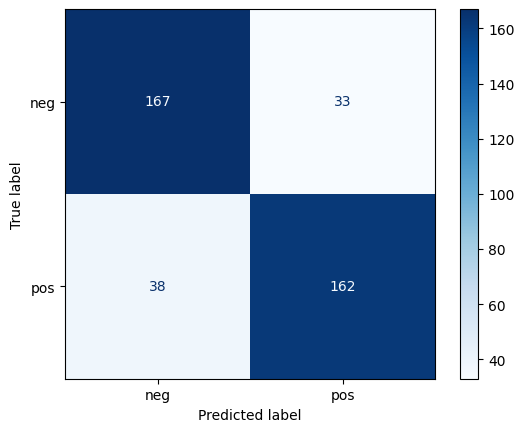

Matriu de confusió del model no supervisat:


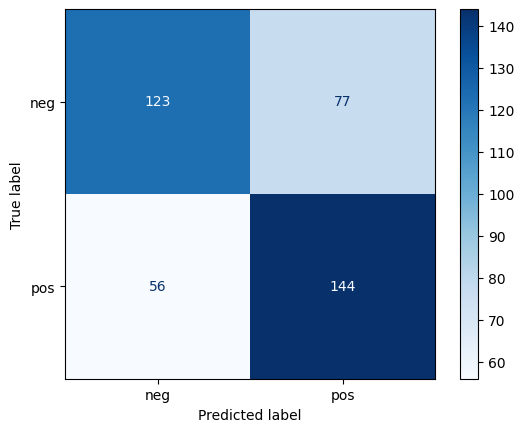

In [120]:
errors_comuns = 0
errors_nomes_supervisats = 0
errors_nomes_no_supervisats = 0
for opinio in range(len(test_x)):
    if prediccions_no_supervistas[opinio] != test_y[opinio] or prediccions_supervisats[opinio] != test_y[opinio]:
        if prediccions_no_supervistas[opinio] == prediccions_supervisats[opinio]:
            errors_comuns += 1
        else:
            if prediccions_supervisats[opinio] == test_y[opinio]:
                errors_nomes_no_supervisats += 1
            else:
                errors_nomes_supervisats += 1

print(f'Errors comuns: {errors_comuns}')
print(f'Errors només supervisats: {errors_nomes_supervisats}')
print(f'Errors només no supervisats: {errors_nomes_no_supervisats}')

print('-----------------------------------')

print('Matriu de confusió del model supervisat:')
cm = confusion_matrix(test_y, prediccions_supervisats)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg', 'pos'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Matriu de confusió del model no supervisat:')
cm = confusion_matrix(test_y, prediccions_no_supervistas)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg', 'pos'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
